# USD AAI 500 final project - Group 3
Group members

- Victoria Dorn
- Victor Hugo Germano

In [7]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import math

sns.set()

# Data Cleaning and Organization

In [95]:
# Card info
cards_csv = pd.read_csv('../dataset/cards.csv', sep=";")
prices_csv = pd.read_csv('../dataset/cardPrices.csv', sep=",")

# perform inner join based on UUID, then drop null values
all_data = pd.merge(prices_csv, cards_csv, on="uuid")
all_data.dropna(inplace=True)
data = all_data.reset_index(drop=True)

# Decided to go with USD only analysis at first, to compare prices more aproprietly
data_usd = data[data['currency'] == 'USD']


# Artists affect prices?

Assuming USD only for analysis

- Null hypothesis $H_0$: artists have no impact on prices
- Alt hypothesis $H_A$: artists do have an impact

## Intepretation

The F-statistic of 7.2039 suggests that there is a significant amount of variance between the average prices of cards from different artists compared to the variance within each artist's prices.

Since the P-value is significantly less than 0.05, you can reject the null hypothesis (H0), which states that artists have no impact on prices.


### Implications
**Artist Impact:** The results suggest that the artist associated with a card does influence its price, meaning that some artists may produce cards that are valued more highly in the market than others.

**Market Insights:** For collectors and sellers, understanding these differences can inform buying and pricing strategies.

In [4]:
# Hypothesis H0: Artists have no impact on prices

# groups mean prices by artists
artists = data_usd['artist'].unique()

# Create a group of prices for each unique artist to performing a ANOVA test
artist_price_groups = [ data_usd[data_usd['artist'] == artist]['price'].to_numpy()
    for artist in artists if len(data_usd[data_usd['artist'] == artist]['price']) > 1 ]

# Removing Zero Variance artist prices
filtered_prices = [row for row in artist_price_groups if np.var(row) > 0]

In [101]:
# Conduct the one-way ANOVA
# Paper cards, no outliers, Q1_Q3, only in USD
t_stat, p_value = stats.f_oneway(*filtered_prices)

print("Can artist impact prices: \n Data: Paper cards, no outliers, Q1_Q3, only in USD")
print("T-statistic ANOVA: %.4f" % t_stat)
print("P-value: %.6f" % p_value);

if p_value < 0.05:
    print("Reject the null hypothesis. There is a statistically significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no statistically significant difference.")


Can artist impact prices: 
 Data: Paper cards, no outliers, Q1_Q3, only in USD
T-statistic ANOVA: 7.2039
P-value: 0.000000
Reject the null hypothesis. There is a statistically significant difference.


---

# Prediction Exercises

Trying to understand what affects the price the most

In [102]:
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
    return filtered_data

# Create linear regression model and use it based on selected feature and target
def prediction(feature, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression().fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_test, y_pred, mse, r2


In [112]:
# DATA SELECTION
label_encoder = LabelEncoder()

# User paper Game Availability given the price variance difference between mtgo and paper
paper = removeOutliers(data_usd, 'price').reindex()

# One-hot encode important variables
to_encode = ['rarity','colorIdentity', 'power', 'artist', 'finishes', 'priceProvider', 'setCode']
for enc in to_encode:    
    paper[f'{enc}_encoded'] = label_encoder.fit_transform(paper[enc])



# Categorical Data
Understanding multicollinearity and where we cant use multiple variables together

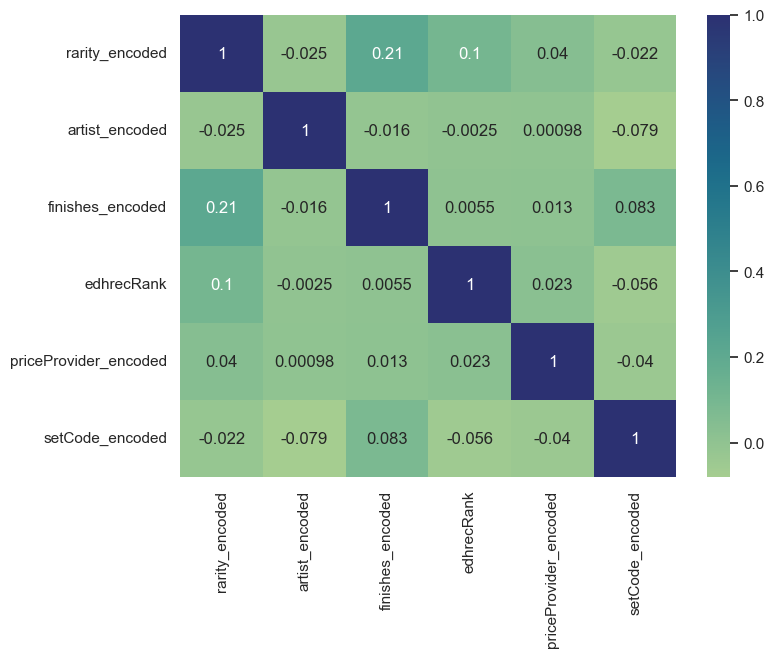

In [119]:
predict_by = ['rarity_encoded', 'artist_encoded', 
              'finishes_encoded', 'edhrecRank', 'priceProvider_encoded', 'setCode_encoded']

plt.figure(figsize=(8,6))
sns.heatmap(paper[predict_by].corr(),annot=True, cmap="crest")
plt.show()

# Price Prediction model - using categorical data

- Mean Squared Error: 1.970043342975583
- R-squared: 0.2172273808523122

Not the best model result

Mean Squared Error: 1.9574846986762644
R-squared: 0.22221740451152439


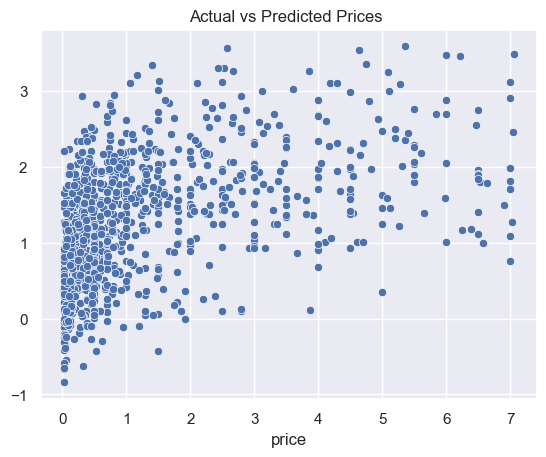

In [122]:
import statsmodels.api as sm
# Price Prediction based on Rank

features = paper[predict_by]
target = paper['price']

# Polinomial Linear Regression
y_test, y_pred, mse, r2 = prediction(features, target)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Ploting results
sns.scatterplot(x=y_test, y=y_pred)
plt.title(f'Actual vs Predicted Prices ')
plt.show()


# OLS data interpretation

## Key Metrics Interpretation

### R-squared and Adjusted R-squared
- **R-squared (0.418)**: Approximately **41.8%** of the variability in card prices can be explained by the independent variables included in the model. 
- **Adjusted R-squared (0.417)**: indicates that the model's explanatory power remains consistent even after accounting for additional variables.

### F-statistic and Prob (F-statistic)
- **F-statistic (550.1)**: Sugests that at least one predictor variable significantly contributes to explaining the variability in price.
- **Prob (F-statistic) (0.00)**: Model is statistically significant, where independent variables collectively have a significant effect on card prices.

## Conclusions

Highest Contributors to price increse

- **Finishes Encoded**: Coefficient: **0.1251** suggests that cards with different finishes (like foil) tend to be priced higher by about $0.13 on average.
- **Price Provider Encoded**: - Coefficient: **0.3187** indicates that different price providers contribute to higher prices on average, which is statistically significant.

The OLS regression results suggest that several factors significantly influence card prices, including rarity, power, artist identity, finish type, EDHREC rank, price provider, and set code.

1) The negative impact of rarity on price may indicate market dynamics where rarer cards are less frequently sold or valued differently.
2) The positive relationship between power and price suggests that more powerful cards are valued higher by collectors and players.
3) Collectors and sellers can leverage these insights to inform pricing strategies based on card attributes.

In [123]:
# Checking statsmodel OLS
model = sm.OLS(target,features) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.392
Model:                            OLS   Adj. R-squared (uncentered):              0.391
Method:                 Least Squares   F-statistic:                              577.3
Date:                Thu, 03 Oct 2024   Prob (F-statistic):                        0.00
Time:                        10:25:35   Log-Likelihood:                         -10117.
No. Observations:                5379   AIC:                                  2.025e+04
Df Residuals:                    5373   BIC:                                  2.029e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
rarity_encoded           -0.2480      0.024    -10.349      0.000      -0.295      -0.201
artist_encoded            0.0030      0.000     10.842      0.000       0.002       0.004
finishes_encoded          0.2280      0.023      9.965      0.000       0.183       0.273
edhrecRank             -3.33e-05   5.14e-06     -6.475      0.000   -4.34e-05   -2.32e-05
priceProvider_encoded     0.3663      0.020     18.656      0.000       0.328       0.405
setCode_encoded           0.0080      0.001     10.736      0.000       0.007       0.009
==============================================================================
Omnibus:                     1549.633   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3671.127
Skew:                           1.621   Prob(JB):                         0.00
Kurtosis:                       5.422   Cond. No.                     8.41e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image, display
import time

data = pd.read_csv('../dataset/mapped_data.csv', sep=',')

# normalize
scaler = MinMaxScaler()
norm_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


display(norm_data.head())

,price,edhrecRank,edhrecSaltiness,manaValue,currency,gameAvailability,providerListing,hasFoil,hasNonFoil,supertypes
0,0.000035,0.369006,0.321429,0.636364,1.0,1.0,1.0,1.0,1.0,1.0
1,0.000070,0.369006,0.321429,0.636364,1.0,1.0,1.0,1.0,1.0,1.0
2,0.006497,0.369006,0.321429,0.636364,1.0,0.0,1.0,1.0,1.0,1.0
3,0.101823,0.369006,0.321429,0.636364,1.0,0.0,1.0,1.0,1.0,1.0
4,0.003144,0.369006,0.321429,0.636364,0.0,0.0,1.0,1.0,1.0,1.0


In [50]:

stime= time.time()
som_size = 10
som_shape = (som_size, som_size)

som = MiniSom(som_size, som_size, norm_data.shape[1] , sigma=1.0, learning_rate=0.5)

to_train = norm_data.values
som.train(to_train, num_iteration=100000)

etime=time.time() - stime 

print(etime, " seconds")
print('winning neuron ',som.winner(to_train[0]))


# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in to_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

1.7202529907226562  seconds
winning neuron  (np.int64(5), np.int64(0))


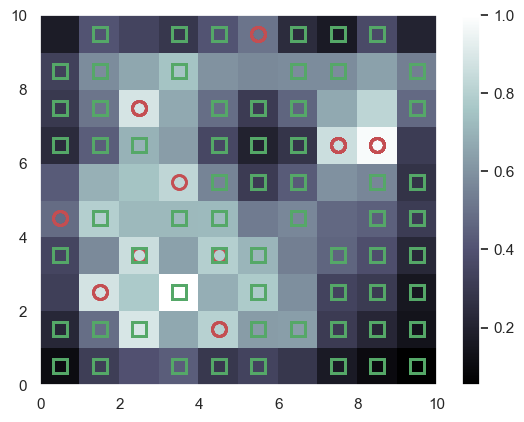

In [53]:
from pylab import bone, pcolor, colorbar, plot, show
y = data.iloc[:, -1].values

bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(to_train):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

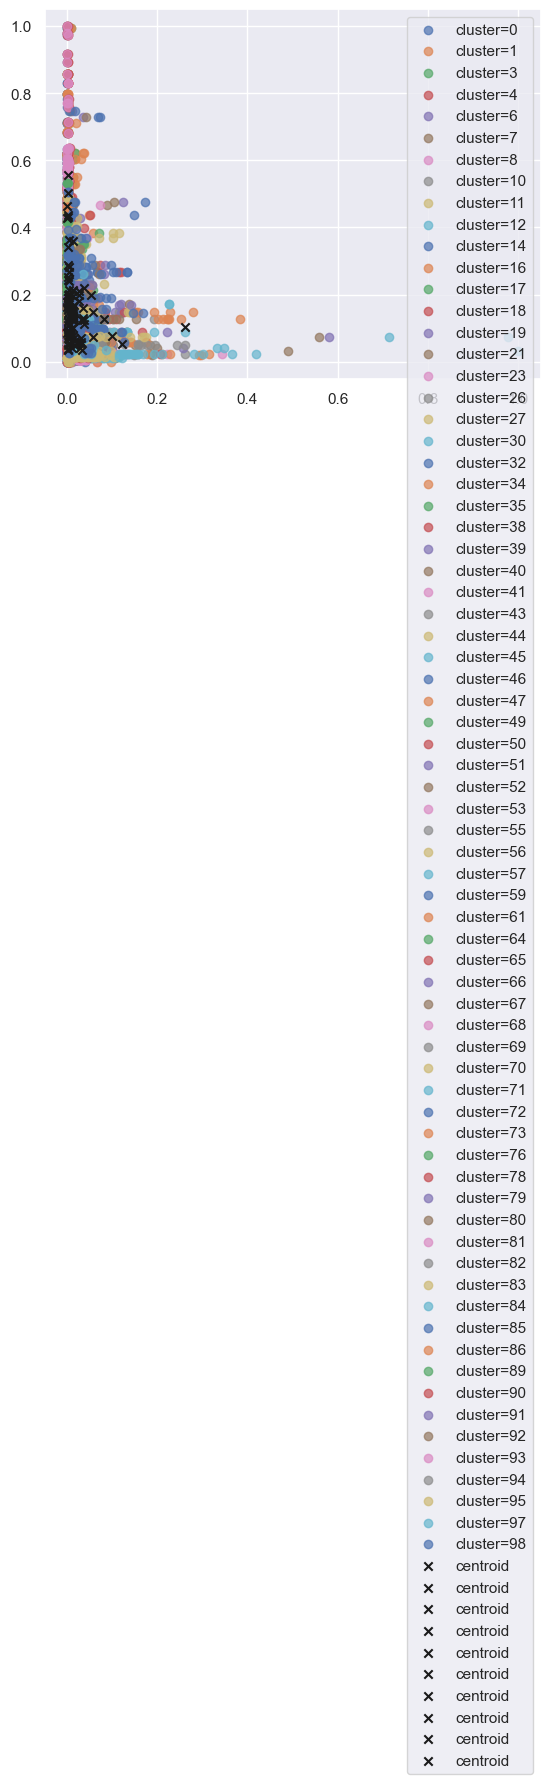

In [51]:

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(to_train[cluster_index == c, 0],
                to_train[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', color='k', label='centroid')
plt.legend();
plt.show()

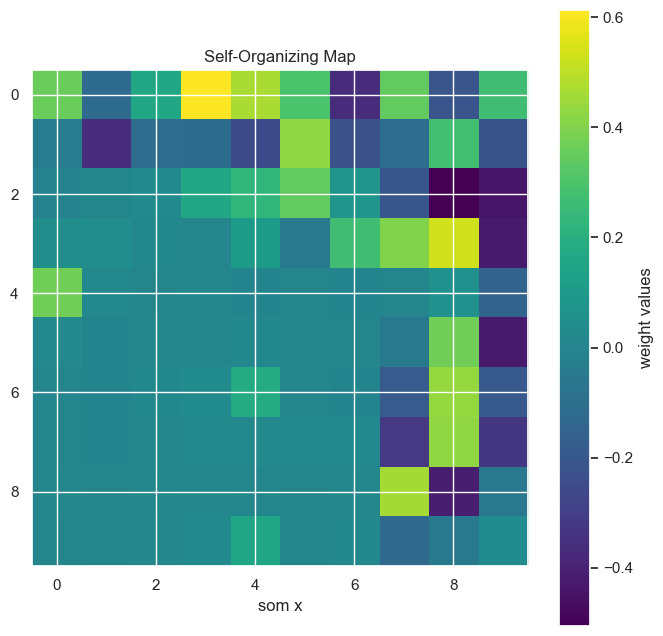

In [28]:

plt.figure(figsize=(8,8))
weights = som.get_weights()
plt.imshow(weights[:,:,0], interpolation='nearest', cmap='viridis')
plt.colorbar(label='weight values')
plt.title("Self-Organizing Map")
plt.xlabel("som x")
plt.show()

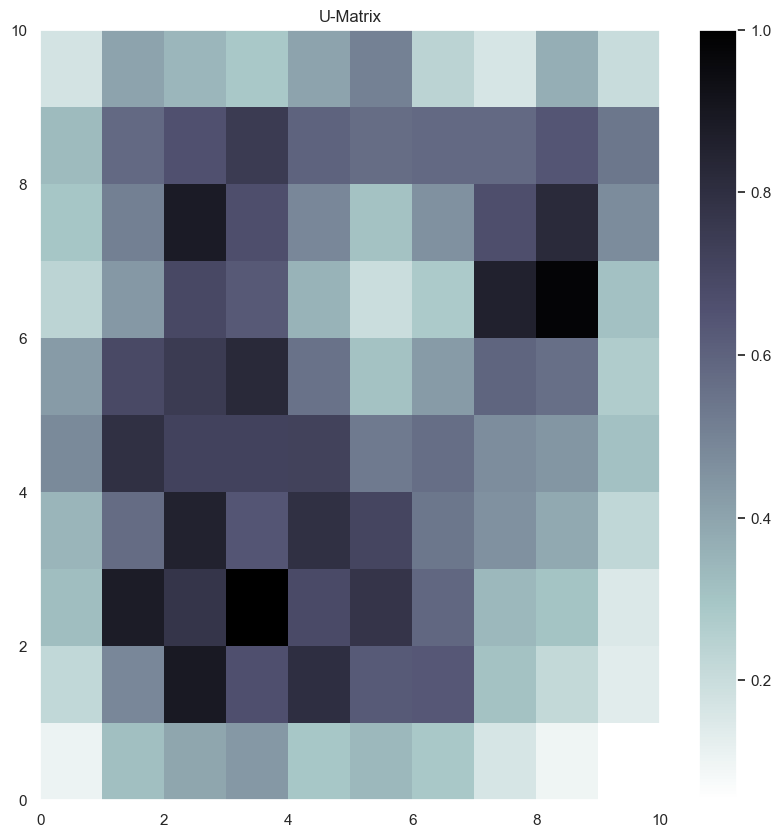

In [52]:
# Plot the distance map (U-matrix)
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map
plt.colorbar()
plt.title('U-Matrix')
plt.show()
